<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install phik -q

In [2]:
!pip install --upgrade scikit-learn -q

In [3]:
!pip install --upgrade numba -q

In [4]:
#!pip install shap -q

In [5]:
!pip install lightgbm --upgrade -q

In [6]:
!pip install category_encoders -q

In [7]:
!pip install pmdarima -q

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import phik
import math
#import shap
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.seasonal import seasonal_decompose
from phik import resources, report
from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import randint, mode
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from category_encoders import BinaryEncoder
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    roc_auc_score,
    make_scorer,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
#from imblearn.over_sampling import SMOTE

In [9]:
data_taxi = pd.read_csv('/datasets/taxi.csv', sep = ',', index_col=[0], parse_dates=[0])

In [10]:
data_taxi.sort_index(inplace=True)

In [11]:
def inf(df, r):
    df1=df.head(r)
    df2=df.info()
    return display(df1, df2)

In [12]:
inf(data_taxi, 10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


None

In [13]:
print(data_taxi.index.is_monotonic)

True


In [14]:
data_taxi = data_taxi.resample('1H').sum()
data_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Данные загружены, соответствуют описанию, типы данных в порядке, пропусков в данных нет.**

**Проверим данные на дубликаты и удалим их, в случае наличия.**

In [15]:
data_taxi.index.duplicated().sum()

0

**Дубликаты отсутствуют. Перезодим к анализу.**

## Анализ

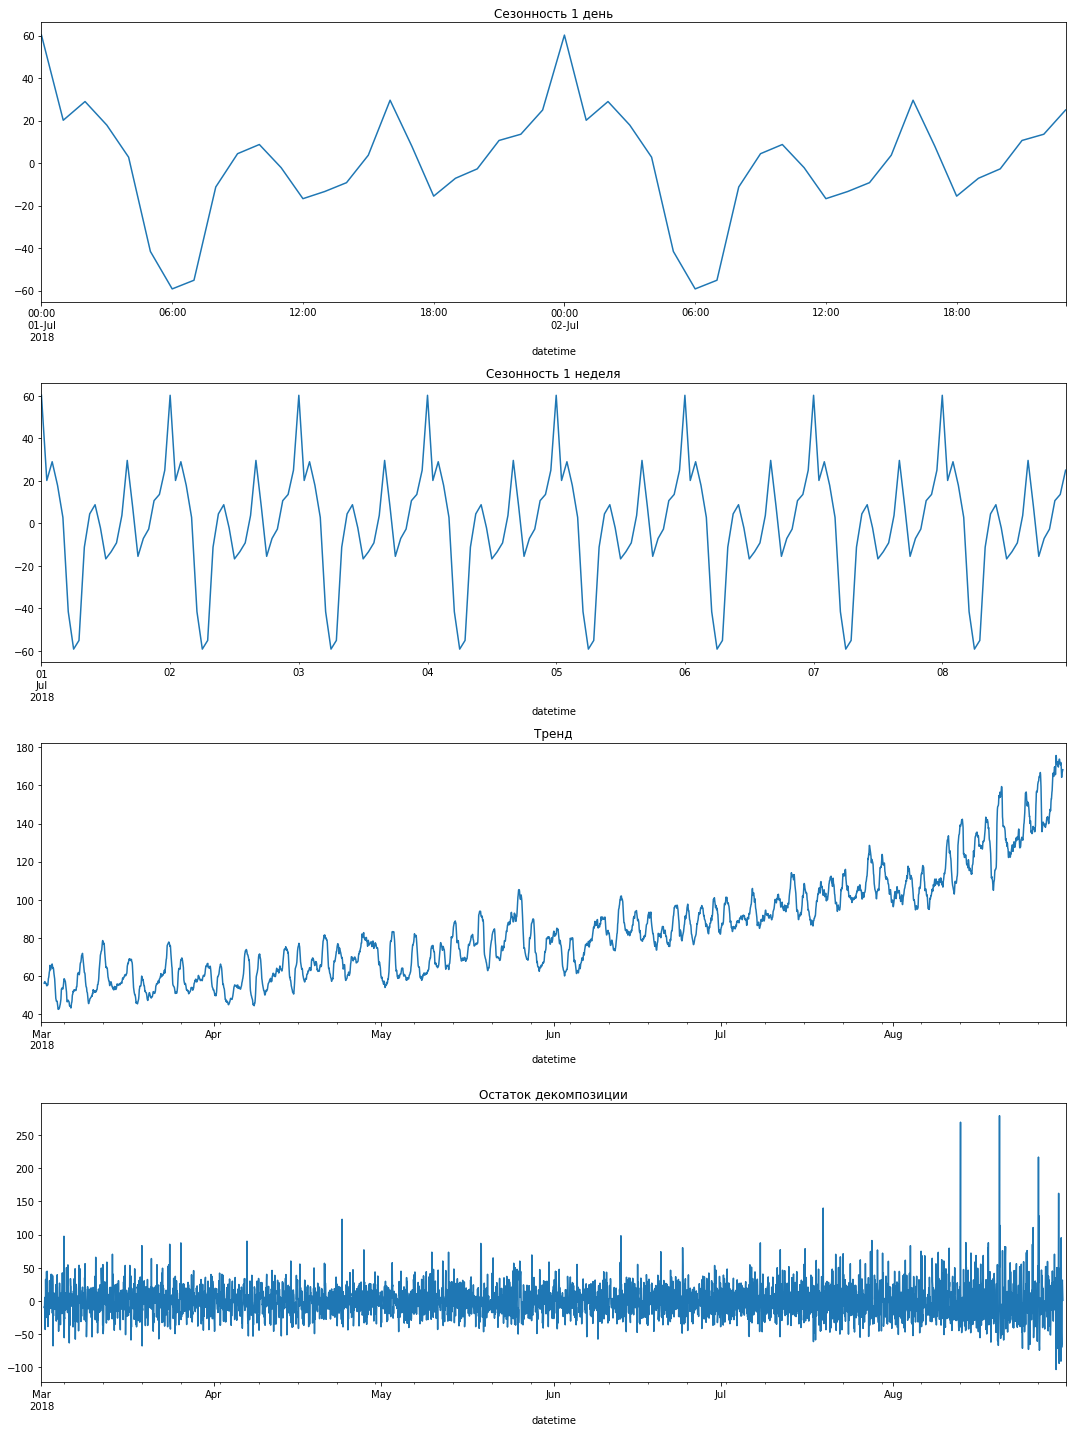

In [16]:
decomposed = seasonal_decompose(data_taxi)

plt.figure(figsize=(15,20))
plt.subplot(411)
decomposed.seasonal['2018-07-01':'2018-07-02'].plot(ax=plt.gca()) 
plt.title('Сезонность 1 день')
plt.subplot(412)
decomposed.seasonal['2018-07-01':'2018-07-08'].plot(ax=plt.gca()) 
plt.title('Сезонность 1 неделя')
plt.subplot(413)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.tight_layout()

**График сезонности показывает всплеск количества заказов в "час-пик", в конце рабочего дня (около 16.00-17.00), и ночью (пик около 0.00), когда заканчивается движение общественного транспорта. В разрезе недели видим цикличность этой картины, каждый день всплески и провалы повторяются в одни и те же часы.**

**Тренд показывает рост количества заказов.**

**Остатки колеблются около нуля с довольно стабильной амплитудой, что говорит о том, что сезонность и тренд выявлены достаточно точно. Имеются всплески в августе, что может говорить о каких-то событиях а этот период, приведший к скачкам заказов, либо ошибки в данных.**

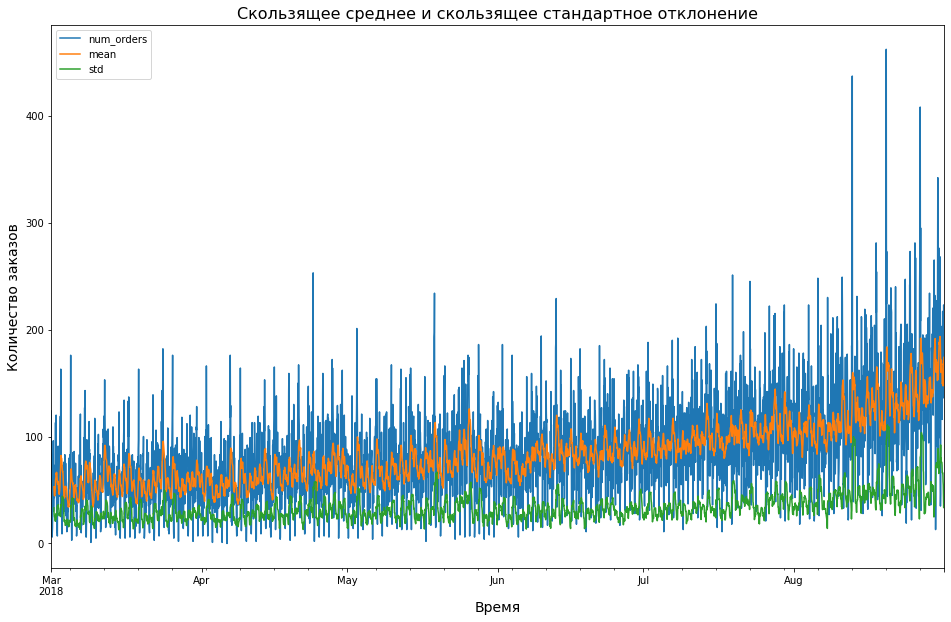

In [17]:
data_taxi['mean'] = data_taxi['num_orders'].rolling(15).mean()
data_taxi['std'] = data_taxi['num_orders'].rolling(15).std()
plt.figure(figsize=(16, 10)) 
data_taxi.plot(ax=plt.gca())
plt.title('Скользящее среднее и скользящее стандартное отклонение', fontsize=16)
plt.xlabel('Время', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.show()

**На данном графике также видим рост среднего количества заказов в течение рассматриваемого периода. Стандартное отклонение довольно стабильно, за исключением августа, где наблюдаются скачки.**

**Применим тест Дики-Фуллера для проверки стационарности нашего временного ряда.**

In [18]:
# Применение теста Дики-Фуллера
result_df = adfuller(data_taxi['num_orders'])

# Вывод результатов
print('Критерий ADF:', result_df[0])
print('p-value:', result_df[1])
print('Критические значения:', result_df[4])

Критерий ADF: -3.0689242890279558
p-value: 0.028940051402612906
Критические значения: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


**В данном случае критерий ADF (-3.0689) меньше критического значения на уровне 5% (-2.8622), и p-value (0.0289) меньше 0.05, значит мы можем отвергнуть нулевую гипотезу о нестационарности, наш временной ряд можно считать стационарным на уровне значимости 5%.**

## Обучение

**Для подбора оптимального количества лагов и размера окна, проведём сначала анализ автокорреляции.**

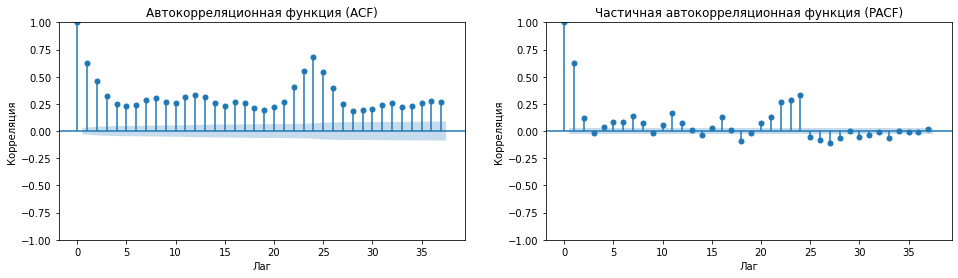

In [19]:
#Построение графиков ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data_taxi['num_orders'].dropna(), ax=axes[0])
axes[0].set_title('Автокорреляционная функция (ACF)')
axes[0].set_xlabel('Лаг')
axes[0].set_ylabel('Корреляция')
plot_pacf(data_taxi['num_orders'].dropna(), ax=axes[1])
axes[1].set_title('Частичная автокорреляционная функция (PACF)')
axes[1].set_xlabel('Лаг')
axes[1].set_ylabel('Корреляция')
plt.show()

**На графике автокорреляции видим постепенное затухание, что указывает на наличие тренда, а пики на определённых интервалах указывает на сезонность (повторение картины каждые 24 часа). Учитывая данные графиков, логично выбрать количество лагов 1 или другое количество с шагом в 24 часа. Подберём оптимальное количество методом перебора параметров на примере одной из моделей.**

**Исходя из данных графиков можно взять размер окна равный 24, а количество лаг 2. Однако дальнейшие расчёты с этими параметрами не приводят к требуемым результатам, поэтому использую другой способ подбора параметров.**

**Нам необходимо разные модели с различными гиперпараметрами, которые будут прогнозировать количество заказов такси на следующий час. Сделаем тестовую выборку размером 10% от исходных данных. Начнём с создания дополнительных признаков. Учитывая временной ряд и сезонность, добавим в качестве дополнительных признаков час и день. Создадим функцию.**

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [21]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

**Определим оптимальное количество лаг и размер окна перебором в цикле на примере одной из моделей (возьмём дерево решений).**

In [22]:
%%time
RANDOM_STATE = 42

lag_range = range(1, 200, 10)  
window_range = range(1, 120, 24)   

best_score = float('inf')
best_params = None

model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

param_grid = {
    'max_depth': range(2, 30),
    'max_features': range(1, 200),
}

results = pd.DataFrame(columns=['Лаг', 'Размер окна', 'RMSE модели'])

for max_lag in lag_range:
    for rolling_mean_size in window_range:
        
        data_with_features = make_features(data_taxi.copy(), max_lag, rolling_mean_size)
        
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            data_with_features.drop(columns=['num_orders'], axis=1),
            data_with_features['num_orders'],
            shuffle=False,
            test_size=0.2,
            random_state=RANDOM_STATE
        )
        
        X_valid, X_test, y_valid, y_test = train_test_split(
            X_temp, y_temp, shuffle=False, test_size=0.5, random_state=RANDOM_STATE
        )
        
       
        randomized_search_tree = RandomizedSearchCV(
            model_tree, 
            param_grid, 
            cv=5,
            scoring=rmse_scorer,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

        randomized_search_tree.fit(X_train, y_train)
        y_valid_pred_tree = randomized_search_tree.predict(X_valid)
        rmse_tree = np.sqrt(mean_squared_error(y_valid, y_valid_pred_tree))
        
       
        
        
        if rmse_tree < best_score:
            best_score = rmse_tree
            best_params = (max_lag, rolling_mean_size)
        
        results = results.append({'Лаг': max_lag, 'Размер окна': rolling_mean_size, 'RMSE модели': rmse_tree}, ignore_index=True)
       
print(results)
print(f'Лучшие параметры: лаг = {best_params[0]}, размер окна = {best_params[1]}')
print(f'Лучший RMSE на валидационной выборке: {best_score}')
      
        

      Лаг  Размер окна  RMSE модели
0     1.0          1.0    35.970574
1     1.0         25.0    36.652869
2     1.0         49.0    36.604328
3     1.0         73.0    36.526878
4     1.0         97.0    38.182453
..    ...          ...          ...
95  191.0          1.0    39.132128
96  191.0         25.0    39.132128
97  191.0         49.0    39.132128
98  191.0         73.0    35.271150
99  191.0         97.0    35.271150

[100 rows x 3 columns]
Лучшие параметры: лаг = 171, размер окна = 1
Лучший RMSE на валидационной выборке: 31.671734370377145
CPU times: user 13min, sys: 967 ms, total: 13min 1s
Wall time: 13min 3s


**Лучшие 10 комбинаций количества лаг и размера окна:**

In [23]:
results = results.sort_values(by='RMSE модели').reset_index(drop=True)
print(results.head(10))

     Лаг  Размер окна  RMSE модели
0  171.0          1.0    31.671734
1  171.0         49.0    32.940947
2  171.0         73.0    32.943543
3  171.0         25.0    32.943759
4  171.0         97.0    32.964445
5  101.0          1.0    33.640412
6  101.0         25.0    33.640412
7  101.0         97.0    33.640412
8  101.0         73.0    33.640412
9  101.0         49.0    33.640412


**Применим лучшие параметры для обучения других моделей.**

In [24]:
make_features(data_taxi, best_params[0], best_params[1])

,num_orders,mean,std,hour,day,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,NaN,NaN,2,1,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,NaN,NaN,3,1,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,NaN,NaN,4,1,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,147.333333,57.917018,19,31,207.0,217.0,197.0,116.0,133.0,...,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,188.0,207.0
2018-08-31 20:00:00,154,152.400000,54.650578,20,31,136.0,207.0,217.0,197.0,116.0,...,246.0,273.0,173.0,242.0,166.0,179.0,113.0,137.0,170.0,136.0
2018-08-31 21:00:00,159,160.666667,43.955605,21,31,154.0,136.0,207.0,217.0,197.0,...,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,137.0,154.0


In [25]:
data_taxi = data_taxi.dropna()

**Обучим модели, найдём лучшую.**

In [26]:
RANDOM_STATE = 42

X_train, X_temp, y_train, y_temp = train_test_split(
    data_taxi.drop(columns=['num_orders'], axis=1),
    data_taxi['num_orders'], 
    shuffle=False, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp, 
    shuffle=False, 
    test_size=0.5, 
    random_state=RANDOM_STATE
)


print(f'Диапазон обучающей выборки: от {X_train.index.min()} до {X_train.index.max()}')
print(f'Диапазон валидационной выборки: от {X_valid.index.min()} до {X_valid.index.max()}')
print(f'Диапазон тестовой выборки: от {X_test.index.min()} до {X_test.index.max()}')

Диапазон обучающей выборки: от 2018-03-08 03:00:00 до 2018-07-27 14:00:00
Диапазон валидационной выборки: от 2018-07-27 15:00:00 до 2018-08-14 06:00:00
Диапазон тестовой выборки: от 2018-08-14 07:00:00 до 2018-08-31 23:00:00


In [27]:
%%time
RANDOM_STATE = 42
param_grid = {
    'n_estimators': [20, 50, 70, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves': [20, 50, 70, 100, 150],
    'max_depth': [2, 5, 7, 10]
}

model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE)

randomized_search_lgb = RandomizedSearchCV(
    model_lgb, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_lgb.fit(X_train, y_train)
y_valid_pred_lgb = randomized_search_lgb.predict(X_valid)
rmse_lgb = np.sqrt(mean_squared_error(y_valid, y_valid_pred_lgb))

print(f'Параметры лучшей модели: {randomized_search_lgb.best_params_}')
print('Лучшая модель и её параметры:\n\n', randomized_search_lgb.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_lgb.best_score_)
print(f'Метрика RMSE на валидационной выборке: {rmse_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30218
[LightGBM] [Info] Number of data points in the train set: 2716, number of used features: 176
[LightGBM] [Info] Start training from score 80.138807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29726
[LightGBM] [Info] Number of data points in the train set: 2717, number of used features: 176
[LightGBM] [Info] Start training from score 78.004049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29515
[LightGBM] [Info] Number of data points in the train set: 2717, number of used features: 176
[LightGBM] [Info] Star

In [28]:
%%time
param_grid = {
    'kernel': ['sigmoid', 'poly', 'rbf'],
    'degree': range(2, 6),
    'C': np.linspace(0.1, 1, 10)
}


model_svr = SVR()

randomized_search_svr = RandomizedSearchCV(
    model_svr, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_svr.fit(X_train, y_train)
y_valid_pred_svr = randomized_search_svr.predict(X_valid)
rmse_svr = np.sqrt(mean_squared_error(y_valid, y_valid_pred_svr))

print(f'Параметры лучшей модели: {randomized_search_svr.best_params_}')
print('Лучшая модель и её параметры:\n\n', randomized_search_svr.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_svr.best_score_)
print(f'Метрика RMSE на валидационной выборке: {rmse_svr}')

Параметры лучшей модели: {'kernel': 'poly', 'degree': 2, 'C': 0.7000000000000001}
Лучшая модель и её параметры:

 SVR(C=0.7000000000000001, degree=2, kernel='poly')
Метрика лучшей модели на тренировочной выборке: -20.892421183855866
Метрика RMSE на валидационной выборке: 29.58582405955131
CPU times: user 1min 10s, sys: 36.4 ms, total: 1min 11s
Wall time: 1min 11s


In [32]:
%%time
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

param_grid = {
    'max_depth': range(2, 30),
    'max_features': range(1, 190),
}

randomized_search_tree = RandomizedSearchCV(
    model_tree, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_tree.fit(X_train, y_train)
y_valid_pred_tree = randomized_search_tree.predict(X_valid)
rmse_tree = np.sqrt(mean_squared_error(y_valid, y_valid_pred_tree))

print(f'Параметры лучшей модели: {randomized_search_tree.best_params_}')
print('Лучшая модель и её параметры:\n\n', randomized_search_tree.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_tree.best_score_)
print(f'Метрика RMSE на валидационной выборке: {rmse_tree}')

Параметры лучшей модели: {'max_features': 89, 'max_depth': 4}
Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=4, max_features=89, random_state=42)
Метрика лучшей модели на тренировочной выборке: -23.517349367694848
Метрика RMSE на валидационной выборке: 34.501703928440904
CPU times: user 11.5 s, sys: 3.94 ms, total: 11.5 s
Wall time: 11.5 s


**Из рассмотренных моделей лучшие результаты показала LGBMRegressor() со следующими параметрами:**
- num_leaves = 150,
- n_estimators = 70, 
- max_depth = 5, 
- learning_rate = 0.1

**Метрика RMSE на валидационной выборке: 27.9**

## Тестирование

**Проведём тестирование лучшей модели на тестовых данных.**

In [33]:
y_test_pred_lgb = randomized_search_lgb.predict(X_test)
rmse_lgb_test = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
print(f'Метрика RMSE на тестовой выборке: {rmse_lgb_test}')

Метрика RMSE на тестовой выборке: 45.495356612706765


**Результаты удовлетворяют требованиям заказчика, RMSE на тестовых данных меньше 48.**

## Вывод

**В ходе данной работы нами были проанализированы данные по количеству заказов такси за несколько месяцев, сделана необходимая подготовка данных, подобраны параметры и обучены модели, предсказывающие количество заказов в час. Лучшие результаты показала модель LGBMRegressor() со следующими параметрами:**
- num_leaves = 150,
- n_estimators = 70, 
- max_depth = 5, 
- learning_rate = 0.1.

**На валидационной выборке получили  RMSE 27.9, на тестовой 45.5, что удовлетворяет ТЗ с требованием RMSE менее 48.**

**Заказчику рекомендовано применение полученной модели для прогнозирования количества заказов на следующий час с целью привлечения большего количества водителей в периоды пиковой нагрузки.**

<div class="alert alert-info"> <b>Сделано✔️</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48